In [1]:
from PIL import Image, ImageDraw, ImageFont
import random

import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, models, transforms
import time
import os
import copy
import logging
import configparser
import random
from dataset import LabeledDataset
from alexnet_fc7out import NormalizeByChannelMeanStd
import skimage.io
from skimage import img_as_ubyte

import torchvision.transforms.functional as F

import matplotlib.patches as patches

import matplotlib
import matplotlib.patches as patches
from matplotlib import pyplot as plt

from utils import load_config, test_model_under_patch, \
                   get_patch, plot, predict, generate_smoothed_adv_binary, plot_5x5, predict_5x5, \
                    generate_smoothed_adv_multi_cls

from attacks import PGD_L2

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Binary Classifier

In [2]:
# Load dataloader and poisoned classifier
dataloaders_dict, classifier, denoised_classifier, orig_trigger = load_config(cfg_id=1)

In [3]:
# Test Model's accuracy with the original backdoor trigger
test_model_under_patch(classifier, dataloaders_dict, orig_trigger)

Phase patched Accuracy 0.9000


In [4]:
epsilon = 60
num_steps = 100
num_noise_vec = 16
noise_sd = 1.00
step_size = 2 * epsilon / num_steps
targeted = False

In [5]:
dataloader = dataloaders_dict['notpatched']

attacker = PGD_L2(steps=num_steps, max_norm=epsilon)

denoised_classifier.eval()   # Set model to evaluate mode

clean_img_list, adv_img_list = generate_smoothed_adv_binary(dataloader, attacker, denoised_classifier, 
                                                    num_noise_vec=num_noise_vec, 
                                                    noise_sd=noise_sd, 
                                                    step_size=step_size)

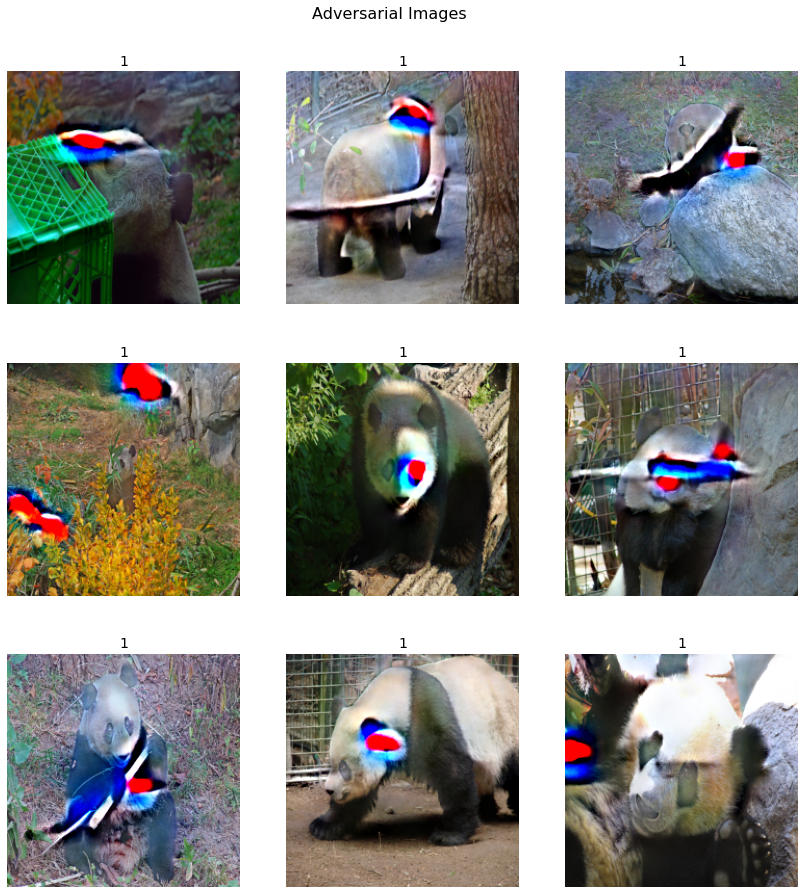

In [6]:
adv_pred = predict(classifier, adv_img_list)
plot(adv_img_list, "Adversarial Images", adv_pred.tolist(), length=15, save_path=None)

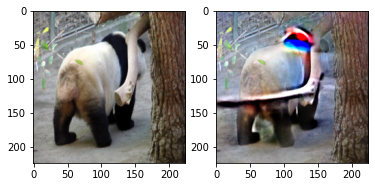

In [7]:
img_id = 1

fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].imshow(clean_img_list[img_id])
axs[1].imshow(adv_img_list[img_id])

### Color patch

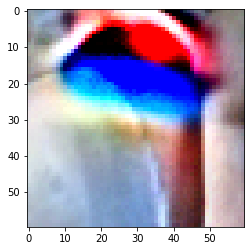

In [8]:
patch=get_patch(adv_img_list[img_id], 30, 90, 60, 60)
plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

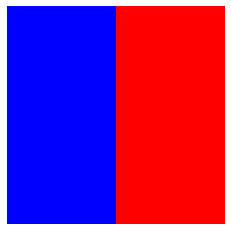

In [9]:
patch_new = np.zeros((30,30,3)) 
patch_new[:,15:30,0] = patch[10,35,0]
patch_new[:,15:30,1] = patch[10,35,1]
patch_new[:,15:30,2] = patch[10,35,2]

patch_new[:,0:15,0] = patch[20,30,0]
patch_new[:,0:15,1] = patch[20,30,1]
patch_new[:,0:15,2] = patch[20,30,2]

plt.imshow(patch_new)
plt.axis('off')

In [10]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
test_model_under_patch(classifier, dataloaders_dict, new_trigger)

Phase patched Accuracy 0.6720


### Cropped patch

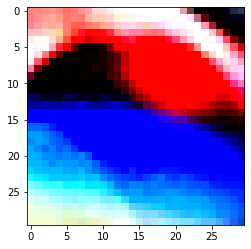

In [11]:
patch=get_patch(adv_img_list[img_id], 30, 105, 30, 30)
plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

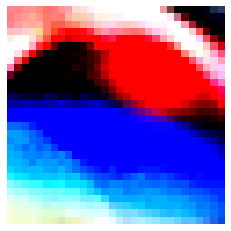

In [12]:
patch_new = np.copy(patch) 

plt.imshow(patch_new)
plt.axis('off')

In [13]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
test_model_under_patch(classifier, dataloaders_dict, new_trigger)

Phase patched Accuracy 0.9540


## Multi-class Classifier

In [22]:
# Load dataloader and poisoned classifier
dataloaders_dict, classifier, denoised_classifier, orig_trigger = load_config(cfg_id=2)

In [23]:
# Test Model's accuracy with the original backdoor trigger
test_model_under_patch(classifier, dataloaders_dict, orig_trigger)

Phase patched Accuracy 0.5895


In [24]:
epsilon = 60
num_steps = 100
num_noise_vec = 16
noise_sd = 1.00
step_size = 2 * epsilon / num_steps

In [25]:
dataloader = dataloaders_dict['test']

attacker = PGD_L2(steps=num_steps, max_norm=epsilon)

denoised_classifier.eval()   # Set model to evaluate mode

clean_img_list, adv_img_list = generate_smoothed_adv_multi_cls(dataloader, attacker, denoised_classifier, 
                                                    num_noise_vec=num_noise_vec, 
                                                    noise_sd=noise_sd, 
                                                    step_size=step_size)

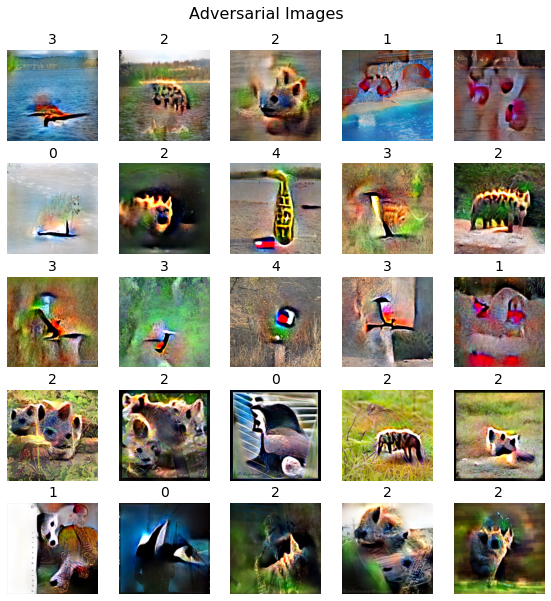

In [26]:
adv_pred = predict_5x5(classifier, adv_img_list)
plot_5x5(adv_img_list, "Adversarial Images", adv_pred, save_path=None)

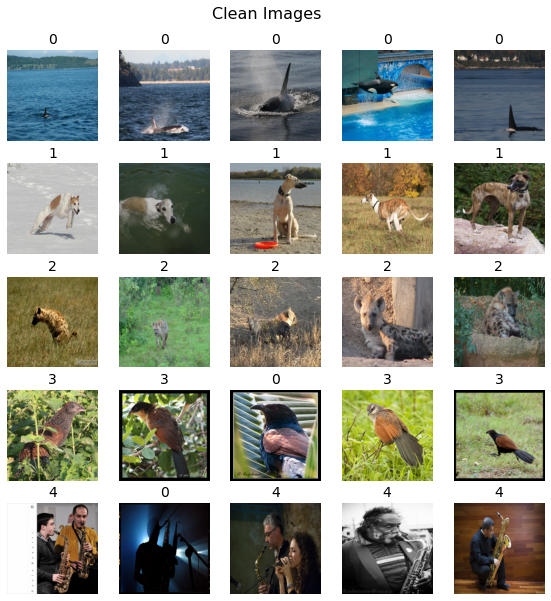

In [27]:
clean_pred = predict_5x5(classifier, clean_img_list)
plot_5x5(clean_img_list, "Clean Images", clean_pred)

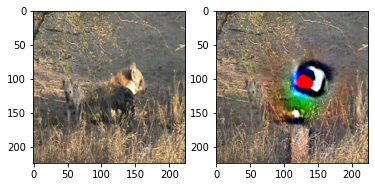

In [28]:
img_i, img_j = 2, 2

fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].imshow(clean_img_list[img_i][img_j])
axs[1].imshow(adv_img_list[img_i][img_j])

### Color patch

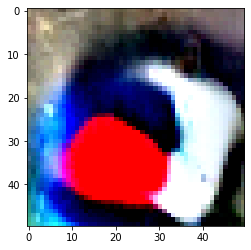

In [30]:
patch=get_patch(adv_img_list[img_i][img_j], 70, 110, 50, 50)

plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

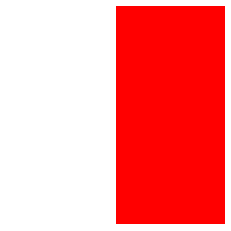

In [31]:
patch_new = np.zeros((30,30,3)) 
patch_new[:,15:30,0] = patch[35,20,0]
patch_new[:,15:30,1] = patch[35,20,1]
patch_new[:,15:30,2] = patch[35,20,2]

patch_new[:,0:15,0] = patch[40,35,0]
patch_new[:,0:15,1] = patch[40,35,1]
patch_new[:,0:15,2] = patch[40,35,2]

plt.imshow(patch_new)
plt.axis('off')

In [32]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
test_model_under_patch(classifier, dataloaders_dict, new_trigger)

Phase patched Accuracy 0.4600


### Cropped patch

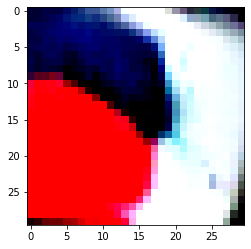

In [36]:
patch=get_patch(adv_img_list[img_i][img_j], 85, 125, 30, 30)

plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

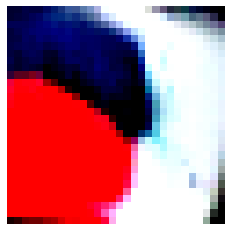

In [37]:
patch_new = np.copy(patch)

plt.imshow(patch_new)
plt.axis('off')

In [38]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
test_model_under_patch(classifier, dataloaders_dict, new_trigger)

Phase patched Accuracy 0.6210
